### This notebook runs ECMWF's aifs-ens-v1 data-driven model, using ECMWF's [open data](https://www.ecmwf.int/en/forecasts/datasets/open-data) dataset and the [anemoi-inference](https://anemoi-inference.readthedocs.io/en/latest/apis/level1.html) package.

aifs-ens-v1 is designed to be an inhererently uncertain model, meaning that for the same initial conditions, different noise is applied within the model and a different forecast will be provided. Here we make a single forecast, from the control initial condition of the ensemble. In operations, this model is run 51 times, once from the control and 50 more times from slightly different initial conditions. Operational AIFS ENS forecast data can be found in ECMWF's [open data](https://www.ecmwf.int/en/forecasts/datasets/open-data) dataset. 

# 1. Install Required Packages and Imports


In [1]:
## Uncomment the lines below to install the required packages
#!pip install torch==2.5.0 anemoi-inference[huggingface]==0.6.0 anemoi-models==0.6.0 anemoi-graphs==0.6.0 anemoi-datasets==0.5.23
#!pip install earthkit-regrid==0.4.0 'ecmwf-opendata>=0.3.19'
#!pip install flash_attn

In [2]:
import datetime
from collections import defaultdict

import numpy as np
import earthkit.data as ekd
import earthkit.regrid as ekr

from anemoi.inference.runners.simple import SimpleRunner
from anemoi.inference.outputs.printer import print_state

from ecmwf.opendata import Client as OpendataClient


# 2. Retrieve Initial Conditions from ECMWF Open Data
## List of parameters to retrieve form ECMWF open data


In [ ]:
PARAM_SFC = ["10u", "10v", "2d", "2t", "msl", "skt", "sp", "tcw"]
PARAM_SFC_FC = ["lsm", "z", "slor", "sdor"]
PARAM_SOIL =["sot"]
PARAM_PL = ["gh", "t", "u", "v", "w", "q"]
LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
SOIL_LEVELS = [1,2]


## Select a date

In [4]:
DATE = OpendataClient("ecmwf").latest()
print("Initial date is", DATE)

Initial date is 2025-06-25 06:00:00


## Get the data from the ECMWF Open Data API


In [ ]:
def get_open_data(param, levelist=[], number = None):
    fields = defaultdict(list)
    # Get the data for the current date and the previous date
    for date in [DATE - datetime.timedelta(hours=6), DATE]:
        if number is None:
            data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist)
        else:
            data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist, number=[number], stream='enfo')
        
        for f in data:
            # Open data is between -180 and 180, we need to shift it to 0-360
            assert f.to_numpy().shape == (721,1440)
            values = np.roll(f.to_numpy(), -f.shape[1] // 2, axis=1)
            # Interpolate the data to from 0.25 to N320
            values = ekr.interpolate(values, {"grid": (0.25, 0.25)}, {"grid": "N320"})
            # Add the values to the list
            name = f"{f.metadata('param')}_{f.metadata('levelist')}" if levelist else f.metadata("param")
            fields[name].append(values)

    # Create a single matrix for each parameter
    for param, values in fields.items():
        fields[param] = np.stack(values)

    return fields

## Get Input Fields

> Here we make a single forecast, from the control initial condition of the ensemble. In operations, this model is run 51 times, once from the control and 50 more times from slightly different initial conditions. 

To get different ensemble initial conditions from the ifs pertubation, set `number` to an ensemble number, between 1-50.


In [6]:
fields = {}
number = None

### Add the single levels fields


In [ ]:
fields.update(get_open_data(param=PARAM_SFC, number=number))
fields.update(get_open_data(param=PARAM_SFC_FC)) # Add constant surface fields, retrieved from fc

In [8]:
soil=get_open_data(param=PARAM_SOIL,levelist=SOIL_LEVELS, number=number)

Soil parameters have been renamed since training this model, we need to rename to the original names

In [9]:
mapping = {'sot_1': 'stl1', 'sot_2': 'stl2',
           'vsw_1': 'swvl1','vsw_2': 'swvl2'}
for k,v in soil.items():
    fields[mapping[k]]=v

### Add the pressure levels fields


In [10]:
fields.update(get_open_data(param=PARAM_PL, levelist=LEVELS, number=number))

### Convert geopotential height into geopotential

In [11]:
# Transform GH to Z
for level in LEVELS:
    gh = fields.pop(f"gh_{level}")
    fields[f"z_{level}"] = gh * 9.80665

## Create Initial State

In [12]:
input_state = dict(date=DATE, fields=fields)

# 3. Load the Model and Run the Forecast

## Download the Model's Checkpoint from Hugging Face & create a Runner


In [13]:
checkpoint = {"huggingface":"ecmwf/aifs-ens-1.0"}

To reduce the memory usage of the model certain environment variables can be set, like the number of chunks of the model's mapper. Please refer to:

https://anemoi.readthedocs.io/projects/models/en/latest/modules/layers.html#anemoi-inference-num-chunks

https://pytorch.org/docs/stable/notes/cuda.html#optimizing-memory-usage-with-pytorch-cuda-alloc-conf

for more information. To do so, you can use the code below:

```
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments:True' 
os.environ['ANEMOI_INFERENCE_NUM_CHUNKS']='16'
```

In [15]:
runner = SimpleRunner(checkpoint, device="cuda")

### Run the forecast

In [16]:
for state in runner.run(input_state=input_state, lead_time=12):
    print_state(state)


😀 date=2025-06-25T12:00:00 latitudes=(542080,) longitudes=(542080,) fields=100

    q_50   shape=(542080,) min=9.71238e-07    max=3.36415e-06   
    t_1000 shape=(542080,) min=234.135        max=323.46        
    v_925  shape=(542080,) min=-39.0201       max=38.1443       
    z_850  shape=(542080,) min=8126.93        max=16131.2       
    ro     shape=(542080,) min=0              max=0.0095754     


😀 date=2025-06-25T18:00:00 latitudes=(542080,) longitudes=(542080,) fields=100

    q_50   shape=(542080,) min=9.82815e-07    max=3.46107e-06   
    t_1000 shape=(542080,) min=234.83         max=320.417       
    v_925  shape=(542080,) min=-35.9961       max=41.1158       
    z_850  shape=(542080,) min=7974.48        max=16173.3       
    ro     shape=(542080,) min=0              max=0.0094197     



# 4. Inspect the generated forecast

### Plot a field


In [17]:
# To be able to run the plotting section below you need to install additional dependencies

# !pip install -q matplotlib cartopy

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.tri as tri

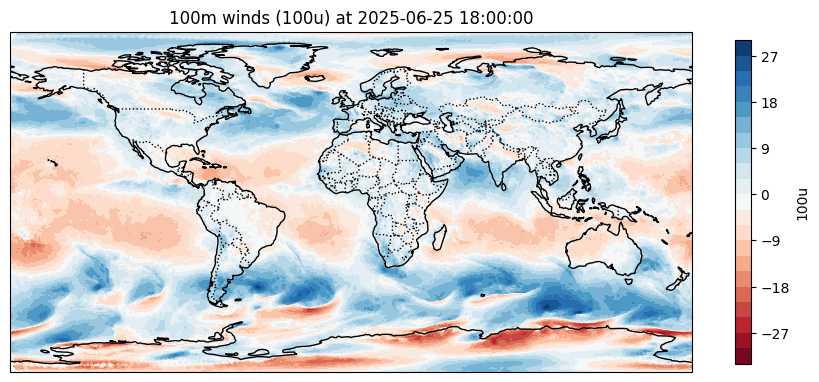

In [19]:
def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

latitudes = state["latitudes"]
longitudes = state["longitudes"]
values = state["fields"]["100u"]

fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

triangulation = tri.Triangulation(fix(longitudes), latitudes)

contour=ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="RdBu")
cbar = fig.colorbar(contour, ax=ax, orientation="vertical", shrink=0.7, label="100u")

plt.title("100m winds (100u) at {}".format(state["date"]))
plt.show()

# 5. Save Forecast Output to Files

## Setup Output Classes for GRIB and NetCDF

In [ ]:
import os
from anemoi.inference.outputs.netcdf import NetCDFOutput
from anemoi.inference.outputs.gribfile import GribFileOutput
from anemoi.inference.context import Context

# Create output directory
output_dir = "forecast_outputs"
os.makedirs(output_dir, exist_ok=True)

# Generate output filenames based on forecast date
date_str = DATE.strftime("%Y%m%d_%H%M")
grib_file = f"{output_dir}/aifs_ens_forecast_{date_str}.grib"
netcdf_file = f"{output_dir}/aifs_ens_forecast_{date_str}.nc"

print(f"Output files will be saved as:")
print(f"  GRIB: {grib_file}")
print(f"  NetCDF: {netcdf_file}")

## Configure Output Objects

Setup the context and output objects for saving forecast results.

In [ ]:
# Create context for outputs
context = Context()
context.time_step = 6  # 6-hour time step
context.lead_time = 72  # 72 hours (3 days) - adjust as needed
context.reference_date = DATE

# Initialize output objects
netcdf_output = NetCDFOutput(context, path=netcdf_file)
grib_output = GribFileOutput(context, path=grib_file)

print("Output objects configured successfully")

## Run Forecast with File Outputs

Run the forecast and save results to both GRIB and NetCDF files.

In [ ]:
# Run forecast with file outputs
forecast_states = []
outputs_initialized = False

for i, state in enumerate(runner.run(input_state=input_state, lead_time=12)):
    # Print progress
    print_state(state)
    
    # Initialize outputs on first state
    if not outputs_initialized:
        netcdf_output.open(state)
        grib_output.open(state)
        outputs_initialized = True
    
    # Write to both outputs
    netcdf_output.write_step(state)
    grib_output.write_step(state)
    
    # Store state for later use
    forecast_states.append(state)

# Close outputs
netcdf_output.close()
grib_output.close()

print(f"\nForecast completed! Generated {len(forecast_states)} time steps.")
print(f"Files saved:")
print(f"  GRIB: {grib_file}")
print(f"  NetCDF: {netcdf_file}")

## Verify Output Files

Check that the files were created successfully and display their properties.

In [ ]:
# Verify output files
print("Checking output files...")

if os.path.exists(grib_file):
    file_size = os.path.getsize(grib_file) / (1024 * 1024)  # Size in MB
    print(f"✓ GRIB file created: {grib_file} ({file_size:.2f} MB)")
else:
    print(f"✗ GRIB file not found: {grib_file}")

if os.path.exists(netcdf_file):
    file_size = os.path.getsize(netcdf_file) / (1024 * 1024)  # Size in MB
    print(f"✓ NetCDF file created: {netcdf_file} ({file_size:.2f} MB)")
else:
    print(f"✗ NetCDF file not found: {netcdf_file}")

# Show file details using earthkit-data (optional)
try:
    print("\nReading back the GRIB file to verify contents:")
    import earthkit.data as ekd
    grib_data = ekd.from_source("file", grib_file)
    print(f"GRIB file contains {len(grib_data)} fields")
    if len(grib_data) > 0:
        print(f"First field: {grib_data[0].metadata()}")
except Exception as e:
    print(f"Could not read GRIB file: {e}")

try:
    print("\nReading back the NetCDF file to verify contents:")
    import xarray as xr
    nc_data = xr.open_dataset(netcdf_file)
    print(f"NetCDF file dimensions: {dict(nc_data.dims)}")
    print(f"NetCDF file variables: {list(nc_data.data_vars.keys())}")
    nc_data.close()
except Exception as e:
    print(f"Could not read NetCDF file: {e}")